Copyright 2020 Andrew M. Olney and made available under [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0) for text and [Apache-2.0](http://www.apache.org/licenses/LICENSE-2.0) for code.

# Crossvalidation and Nested crossvalidation: Problem solving

In this session, you will apply nested crossvalidation to logistic lasso regression, to find the optimal regularization parameter (or penalty term) for predicting breast cancer.

The [data](https://scikit-learn.org/stable/datasets/index.html#breast-cancer-dataset) consists of the following variables as mean, standard error, and "worst" (mean of three largest variables) collected by digital imagery of a biopsy.

| Variable | Type | Description |
|:-------|:-------|:-------|
|radius | Ratio | mean of distances from center to points on the perimeter|
|texture | Ratio | standard deviation of gray-scale values|
|perimeter | Ratio | perimeter of cancer|
|area | Ratio | area of cancer|
|smoothness | Ratio | local variation in radius lengths|
|compactness | Ratio |  perimeter^2 / area - 1.0|
|concavity | Ratio |  severity of concave portions of the contour|
|concave points | Ratio |  number of concave portions of the contour|
|symmetry | Ratio | symmetry of cancer|
|fractal dimension | Ratio | "coastline approximation" - 1|

<div style="text-align:center;font-size: smaller">
    <b>Source:</b> This dataset was taken from the <a href="https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)">UCI Machine Learning Repository library
    </a>
</div>
<br>


In addition to these predictors is the class label:

| Variable | Type | Description |
|:-------|:-------|:-------|
| Target | Nominal (binary) | malignant (1) or benign (0)


The goal is to predict `Target`, i.e. the presence of breast cancer.

### Load data

Import `pandas` so we can load a dataframe.

In [3]:
import pandas as pd

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="A]5Vf/x,=8dk=KKk3OrJ">pd</variable></variables><block type="importAs" id="G*NhDz5Jo?CcaJf3rUv}" x="150" y="308"><field name="libraryName">pandas</field><field name="VAR" id="A]5Vf/x,=8dk=KKk3OrJ">pd</field></block></xml>

Load the dataframe with `datasets/cancer.csv`.

In [5]:
dataframe = pd.read_csv('datasets/cancer.csv')

dataframe

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="Y+grzOaS*0=OHV6zO8m/">dataframe</variable><variable id="A]5Vf/x,=8dk=KKk3OrJ">pd</variable></variables><block type="variables_set" id="^p6DH/6N@h{Uka=BzJ_j" x="9" y="196"><field name="VAR" id="Y+grzOaS*0=OHV6zO8m/">dataframe</field><value name="VALUE"><block type="varDoMethod" id="69MJvg`#}wvn~s)@r$Oy"><mutation items="1"></mutation><field name="VAR" id="A]5Vf/x,=8dk=KKk3OrJ">pd</field><field name="MEMBER">read_csv</field><data>pd:read_csv</data><value name="ADD0"><block type="text" id="h]qBQ;Jd,%5[VFJ{5Qrg"><field name="TEXT">datasets/cancer.csv</field></block></value></block></value></block><block type="variables_get" id="cecq@1cDqS`l`^:tG5pI" x="8" y="296"><field name="VAR" id="Y+grzOaS*0=OHV6zO8m/">dataframe</field></block></xml>

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


## Explore data

Since there are clearly some NaN, `dropna` and store the results back into your dataframe.

In [7]:
dataframe = dataframe.dropna()

dataframe

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="Y+grzOaS*0=OHV6zO8m/">dataframe</variable></variables><block type="variables_set" id="FJGldw(qFp?V=E]uaN)4" x="31" y="222"><field name="VAR" id="Y+grzOaS*0=OHV6zO8m/">dataframe</field><value name="VALUE"><block type="varDoMethod" id="4s18v%0iqE%_l@{fLYCo"><mutation items="1"></mutation><field name="VAR" id="Y+grzOaS*0=OHV6zO8m/">dataframe</field><field name="MEMBER">dropna</field><data>dataframe:dropna</data></block></value></block><block type="variables_get" id="yN6MT1B[)Pk)cEECN_YZ" x="31" y="286"><field name="VAR" id="Y+grzOaS*0=OHV6zO8m/">dataframe</field></block></xml>

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,20.92,25.09,143.00,1347.0,0.10990,0.22360,0.31740,0.14740,0.2149,0.06879,...,29.41,179.10,1819.0,0.1407,0.4186,0.6599,0.2542,0.2929,0.09873,0
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.1410,0.2113,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.1166,0.1922,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.1139,0.3094,0.3403,0.1418,0.2218,0.07820,0


Check the data makes sense with the five figure summary.

In [9]:
dataframe.describe()

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="Y+grzOaS*0=OHV6zO8m/">dataframe</variable></variables><block type="varDoMethod" id="-[lX-}4sT`|#7E(Sti)^" x="78" y="266"><mutation items="1"></mutation><field name="VAR" id="Y+grzOaS*0=OHV6zO8m/">dataframe</field><field name="MEMBER">describe</field><data>dataframe:describe</data></block></xml>

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Target
count,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,...,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000
mean,14.237565,19.259748,92.736673,663.734712,0.096616,0.105679,0.090876,0.050063,0.181278,0.062746,...,25.679388,108.242878,893.412410,0.132824,0.258472,0.278553,0.117286,0.290802,0.084141,0.618705
std,3.482170,4.246993,24.006362,350.893313,0.013895,0.052643,0.079468,0.038517,0.027446,0.007059,...,6.105744,33.337041,569.492912,0.022616,0.156663,0.206803,0.064087,0.062027,0.018130,0.486142
min,7.691000,9.710000,48.340000,170.400000,0.062510,0.019380,0.000692,0.001852,0.116700,0.049960,...,12.020000,54.490000,223.600000,0.081250,0.034320,0.001845,0.008772,0.156500,0.055040,0.000000
25%,11.760000,16.177500,75.845000,427.750000,0.086665,0.066608,0.030880,0.020895,0.161900,0.057675,...,21.160000,84.567500,521.450000,0.117175,0.151175,0.121800,0.065713,0.250900,0.071873,0.000000
50%,13.455000,18.855000,87.090000,557.650000,0.096035,0.095090,0.064905,0.034840,0.179250,0.061515,...,25.445000,98.320000,696.050000,0.131550,0.217000,0.231400,0.101700,0.282450,0.080075,1.000000
75%,16.040000,21.735000,105.250000,798.050000,0.105400,0.130600,0.132325,0.074842,0.195750,0.066090,...,29.547500,126.750000,1106.750000,0.146325,0.341600,0.386200,0.163150,0.318850,0.092095,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


-----------
**QUESTION:**

Do the min, mean, and max look reasonable to you?

**ANSWER: (click here to edit)**


*I really can't say; I don't have enough medical knowledge to fully understand these variables.*
<hr>

**QUESTION:**

What percentage of the data has `Target=1` and `Target=0`?

**ANSWER: (click here to edit)**


*Since `Target` is 0 or 1, and the mean is .618, `Target=1` is 61.8% of the data and `Target=0` is 38.2%*
<hr>

To look at the correlations between variables, create a correlation heatmap.

First import `plotly.express`.

In [12]:
import plotly.express as px

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="+yh,Zg{hON]zy6D~.rH#">px</variable></variables><block type="importAs" id="JKd}DIrGfV*IelKZ!4ls" x="129" y="219"><field name="libraryName">plotly.express</field><field name="VAR" id="+yh,Zg{hON]zy6D~.rH#">px</field></block></xml>

And create a correlation matrix.

In [14]:
corr = dataframe.corr()

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="Nzf/=Q)W#.;)QR}gY_Ur">corr</variable><variable id="Y+grzOaS*0=OHV6zO8m/">dataframe</variable></variables><block type="variables_set" id="g:(h]9_d91#9*:0+_W#-" x="56" y="310"><field name="VAR" id="Nzf/=Q)W#.;)QR}gY_Ur">corr</field><value name="VALUE"><block type="varDoMethod" id="8;d*+wxrr5%F3m!clD{p"><mutation items="1"></mutation><field name="VAR" id="Y+grzOaS*0=OHV6zO8m/">dataframe</field><field name="MEMBER">corr</field><data>dataframe:corr</data></block></value></block></xml>

Show a correlation heatmap with row/column labels.

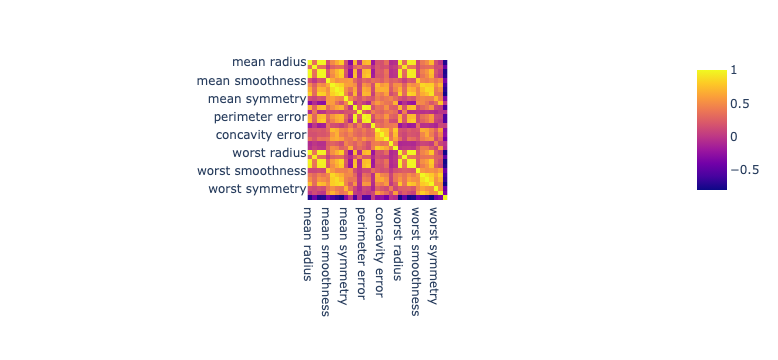

In [16]:
px.imshow(corr,x=corr.columns,y=corr.columns)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="+yh,Zg{hON]zy6D~.rH#">px</variable><variable id="Nzf/=Q)W#.;)QR}gY_Ur">corr</variable></variables><block type="varDoMethod" id=";Cb=u8[v?Z=ZqSh!rye-" x="8" y="176"><mutation items="3"></mutation><field name="VAR" id="+yh,Zg{hON]zy6D~.rH#">px</field><field name="MEMBER">imshow</field><data>px:imshow</data><value name="ADD0"><block type="variables_get" id="8R}*biK{_3*YsC5vT-Sw"><field name="VAR" id="Nzf/=Q)W#.;)QR}gY_Ur">corr</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock" id="P19%UZQYzb=tJWH-[-D."><field name="CODE">x=corr.columns</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock" id="`nYiz=e7MyuC3[iPuHsz"><field name="CODE">y=corr.columns</field></block></value></block></xml>

-----------
**QUESTION:**

What can you say about the correlations amongst the variables?

**ANSWER: (click here to edit)**

*You can see the three group structure referenced in the data description, because each group has similar correlations to all other variables.
It appears the first and third groups are very similar, but the second group is a bit different (less strongly correlated with some variables.
Finally, the class label seems to be negatively correlated with many of the variables and not correlated with a small number of them.*
<hr>


**QUESTION:**

Are there any more plots you'd want to do at this point? Why or why not?

**ANSWER: (click here to edit)**

*We already have the class imbalance from the descriptives. 
We could do a scatterplot matrix to look for nonlinear relationships since that is important for logistic regression.*
<hr>

### Prepare train/test sets

Separate our predictors (`X`) from our class label (`Y`), putting each into its own dataframe.

In [18]:
X = dataframe.drop(columns=["Target"])

Y = dataframe[['Target']]

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="_z/H/tTnOYS1Lla2~;*0">X</variable><variable id="o8#tp%!,_Okj2aVwX(DL">Y</variable><variable id="Y+grzOaS*0=OHV6zO8m/">dataframe</variable></variables><block type="variables_set" id="v$m6b}OQu(wF6Gk!)w:Z" x="95" y="191"><field name="VAR" id="_z/H/tTnOYS1Lla2~;*0">X</field><value name="VALUE"><block type="varDoMethod" id="mA!*r=_YYu?ypCUOhdUQ"><mutation items="1"></mutation><field name="VAR" id="Y+grzOaS*0=OHV6zO8m/">dataframe</field><field name="MEMBER">drop</field><data>dataframe:drop</data><value name="ADD0"><block type="dummyOutputCodeBlock" id="zG~mVrGO2la?/4Tc#+4K"><field name="CODE">columns=["Target"]</field></block></value></block></value></block><block type="variables_set" id="J.(r-ci$Z]0(z{=R,T;+" x="99" y="279"><field name="VAR" id="o8#tp%!,_Okj2aVwX(DL">Y</field><value name="VALUE"><block type="indexer" id="6o/%E8zn:UY-`.k%%dlC"><field name="VAR" id="Y+grzOaS*0=OHV6zO8m/">dataframe</field><value name="INDEX"><block type="lists_create_with" id=".^J[E#0S[3`@2d@+Mu@n"><mutation items="1"></mutation><value name="ADD0"><block type="text" id="M*Uc@Tv*y}{]xN4#,S9j"><field name="TEXT">Target</field></block></value></block></value></block></value></block></xml>

### Train model with nested crossvalidation

Import libraries for 

- Logistic regression (`sklearn.linear_model`)
- Crossvalidation
- `ravel`
- Scale (lasso regression is very sensitive to standardization)
- Pipeline (to combine scaling and modeling)
- Metrics (for evaluation)

In [26]:
import sklearn.linear_model as linear_model
import sklearn.model_selection as model_selection
import numpy as np
import sklearn.preprocessing as pp
import sklearn.pipeline as pipe
import sklearn.metrics as metrics

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="cGnMvhq5543q[r$:Og-x">linear_model</variable><variable id="-q~R*yx.VGQ@%!0Q+!gh">model_selection</variable><variable id="hxqH|@PJU~wrI]t*tHgd">np</variable><variable id=".T`xqZHAu7r0$MQ4s=Yg">pp</variable><variable id="=z9KfSBWpoDS,oj-?yx,">pipe</variable><variable id="jpz]0=,hLYv~rN^#0dFO">metrics</variable></variables><block type="importAs" id="a_VXotnNJ4I;X-InkXS5" x="-3" y="136"><field name="libraryName">sklearn.linear_model</field><field name="VAR" id="cGnMvhq5543q[r$:Og-x">linear_model</field><next><block type="importAs" id="E{QJ$O@lc8u.;OTWdVgf"><field name="libraryName">sklearn.model_selection</field><field name="VAR" id="-q~R*yx.VGQ@%!0Q+!gh">model_selection</field><next><block type="importAs" id="%54AMyx`5atYhM+,;y=E"><field name="libraryName">numpy</field><field name="VAR" id="hxqH|@PJU~wrI]t*tHgd">np</field><next><block type="importAs" id="Y_X_=wl?6L0]3t_pz!qr"><field name="libraryName">sklearn.preprocessing</field><field name="VAR" id=".T`xqZHAu7r0$MQ4s=Yg">pp</field><next><block type="importAs" id="a2fY;O3%6%So/D6a1oop"><field name="libraryName">sklearn.pipeline</field><field name="VAR" id="=z9KfSBWpoDS,oj-?yx,">pipe</field><next><block type="importAs" id="t2i[`M_,(h0KHIF4[UGr"><field name="libraryName">sklearn.metrics</field><field name="VAR" id="jpz]0=,hLYv~rN^#0dFO">metrics</field></block></next></block></next></block></next></block></next></block></next></block></xml>

Create a pipeline to scale and train in one step:
- Call stage 1 `"scale"` and use `StandardScaler`
- Call stage 2 `"lasso"` and use `LogisticRegression` with `penalty="l2"`


In [28]:
model = pipe.Pipeline([('scale',(pp.StandardScaler())), ('lasso',(linear_model.LogisticRegression(penalty="l2")))])

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="WMn%x,]:2AW7#OLRLzEH">model</variable><variable id="=z9KfSBWpoDS,oj-?yx,">pipe</variable><variable id=".T`xqZHAu7r0$MQ4s=Yg">pp</variable><variable id="cGnMvhq5543q[r$:Og-x">linear_model</variable></variables><block type="variables_set" id="/Qq`Z+-E+@?d7iqIa$gt" x="-81" y="270"><field name="VAR" id="WMn%x,]:2AW7#OLRLzEH">model</field><value name="VALUE"><block type="varCreateObject" id="C1|kicy)4reyhtAHqLiy"><mutation items="1"></mutation><field name="VAR" id="=z9KfSBWpoDS,oj-?yx,">pipe</field><field name="MEMBER">Pipeline</field><data>pipe:Pipeline</data><value name="ADD0"><block type="lists_create_with" id="_l)zP/3CzX:}g67,c=WQ"><mutation items="2"></mutation><value name="ADD0"><block type="tupleBlock" id="1maX^Dw3HS=.B.Nu|X36"><value name="FIRST"><block type="text" id="DiZ?E2]);rmc#9%ta{V:"><field name="TEXT">scale</field></block></value><value name="SECOND"><block type="varCreateObject" id="R0A,0sp15n@tOP;u(ZK["><mutation items="1"></mutation><field name="VAR" id=".T`xqZHAu7r0$MQ4s=Yg">pp</field><field name="MEMBER">StandardScaler</field><data>pp:StandardScaler</data></block></value></block></value><value name="ADD1"><block type="tupleBlock" id="X*K@DJs:A2Y[YDBsYLE9"><value name="FIRST"><block type="text" id="zVx=RpJIpMJVwqSv(}r="><field name="TEXT">lasso</field></block></value><value name="SECOND"><block type="varCreateObject" id="7J3ooiL#@;m{L]Z39ntG"><mutation items="1"></mutation><field name="VAR" id="cGnMvhq5543q[r$:Og-x">linear_model</field><field name="MEMBER">LogisticRegression</field><data>linear_model:LogisticRegression</data><value name="ADD0"><block type="dummyOutputCodeBlock" id="G_=6Myq/5e|A}qv]wKgP"><field name="CODE">penalty="l2"</field></block></value></block></value></block></value></block></value></block></value></block></xml>

Create a grid search with:
- `'lasso__C': [.25, .50, .75, 1.0]`
- `cv=10`

Create predictions using `cross_val_predict` with the grid search, data and `cv=10`

In [30]:
gridSearch = model_selection.GridSearchCV(estimator=model,param_grid={'lasso__C': [.25, .50, .75, 1.0]},cv=10)

predictions = model_selection.cross_val_predict(gridSearch,X,np.ravel(Y),cv=10)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="yv+gPAZd/8:NDOnmJ~uf">gridSearch</variable><variable id="(`;mrW|63Vww]$wlV9+1">predictions</variable><variable id="-q~R*yx.VGQ@%!0Q+!gh">model_selection</variable><variable id="_z/H/tTnOYS1Lla2~;*0">X</variable><variable id="hxqH|@PJU~wrI]t*tHgd">np</variable><variable id="o8#tp%!,_Okj2aVwX(DL">Y</variable></variables><block type="variables_set" id="MdOb2;C)R63)q*Rc2=ST" x="-121" y="238"><field name="VAR" id="yv+gPAZd/8:NDOnmJ~uf">gridSearch</field><value name="VALUE"><block type="varCreateObject" id="CH5|hYh%Pz@KaZhFAm=y"><mutation items="3"></mutation><field name="VAR" id="-q~R*yx.VGQ@%!0Q+!gh">model_selection</field><field name="MEMBER">GridSearchCV</field><data>model_selection:GridSearchCV</data><value name="ADD0"><block type="dummyOutputCodeBlock" id="_[*=v~x0I=DYlb0$v*)m"><field name="CODE">estimator=model</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock" id="ei5PqC02zmUAht@0TGE`"><field name="CODE">param_grid={'lasso__C': [.25, .50, .75, 1.0]}</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock" id="|rwaRAwKdlmxrXv[CB5("><field name="CODE">cv=10</field></block></value></block></value></block><block type="variables_set" id="lSvA0DytvC@jnk4`j!b@" x="-138" y="386"><field name="VAR" id="(`;mrW|63Vww]$wlV9+1">predictions</field><value name="VALUE"><block type="varDoMethod" id="-wd!`}p_pK]R$T[Yv{yX"><mutation items="4"></mutation><field name="VAR" id="-q~R*yx.VGQ@%!0Q+!gh">model_selection</field><field name="MEMBER">cross_val_predict</field><data>model_selection:cross_val_predict</data><value name="ADD0"><block type="variables_get" id="1TBz_GS_%,|[%?#+^iOT"><field name="VAR" id="yv+gPAZd/8:NDOnmJ~uf">gridSearch</field></block></value><value name="ADD1"><block type="variables_get" id="XJzP!dqd;3(:hPM;G=ZY"><field name="VAR" id="_z/H/tTnOYS1Lla2~;*0">X</field></block></value><value name="ADD2"><block type="varDoMethod" id="$T?4UUb7hL:@:x}.v2[,"><mutation items="1"></mutation><field name="VAR" id="hxqH|@PJU~wrI]t*tHgd">np</field><field name="MEMBER">ravel</field><data>np:ravel</data><value name="ADD0"><block type="variables_get" id="t88}nxVtUKyz,ou8{:p-"><field name="VAR" id="o8#tp%!,_Okj2aVwX(DL">Y</field></block></value></block></value><value name="ADD3"><block type="dummyOutputCodeBlock" id="|:`mH*(*4#?X?haDRohM"><field name="CODE">cv=10</field></block></value></block></value></block></xml>

### Evaluate the model

Get the accuracy by comparing the predictions to *all* of `Y`.

In [32]:
metrics.accuracy_score(Y,predictions)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="jpz]0=,hLYv~rN^#0dFO">metrics</variable><variable id="o8#tp%!,_Okj2aVwX(DL">Y</variable><variable id="(`;mrW|63Vww]$wlV9+1">predictions</variable></variables><block type="varDoMethod" id="F}9p/^p9*;pp~ZcNuE;@" x="0" y="176"><mutation items="2"></mutation><field name="VAR" id="jpz]0=,hLYv~rN^#0dFO">metrics</field><field name="MEMBER">accuracy_score</field><data>metrics:accuracy_score</data><value name="ADD0"><block type="variables_get" id="LErTj1eg0L*3UA7lXLE{"><field name="VAR" id="o8#tp%!,_Okj2aVwX(DL">Y</field></block></value><value name="ADD1"><block type="variables_get" id="lMeh@i^cTm54?r|qefnC"><field name="VAR" id="(`;mrW|63Vww]$wlV9+1">predictions</field></block></value></block></xml>

0.9802158273381295

Similarly we can get the recall and precision using all of `Y`.

In [34]:
print(metrics.classification_report(Y,predictions))

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="jpz]0=,hLYv~rN^#0dFO">metrics</variable><variable id="o8#tp%!,_Okj2aVwX(DL">Y</variable><variable id="(`;mrW|63Vww]$wlV9+1">predictions</variable></variables><block type="text_print" id="{9DtH#+Zi{1}^((zc[x!" x="87" y="368"><value name="TEXT"><shadow type="text" id="|?Q+,+Qs3m9t(4eE@qGx"><field name="TEXT">abc</field></shadow><block type="varDoMethod" id="F}9p/^p9*;pp~ZcNuE;@"><mutation items="2"></mutation><field name="VAR" id="jpz]0=,hLYv~rN^#0dFO">metrics</field><field name="MEMBER">classification_report</field><data>metrics:classification_report</data><value name="ADD0"><block type="variables_get" id="LErTj1eg0L*3UA7lXLE{"><field name="VAR" id="o8#tp%!,_Okj2aVwX(DL">Y</field></block></value><value name="ADD1"><block type="variables_get" id="lMeh@i^cTm54?r|qefnC"><field name="VAR" id="(`;mrW|63Vww]$wlV9+1">predictions</field></block></value></block></value></block></xml>

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       212
           1       0.97      0.99      0.98       344

    accuracy                           0.98       556
   macro avg       0.98      0.98      0.98       556
weighted avg       0.98      0.98      0.98       556



### Hyperparameter

Use `fit` on the grid search to learn the best overall hyperparameter value for `C`.

In [36]:
gridSearch.fit(X,np.ravel(Y))

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="yv+gPAZd/8:NDOnmJ~uf">gridSearch</variable><variable id="_z/H/tTnOYS1Lla2~;*0">X</variable><variable id="hxqH|@PJU~wrI]t*tHgd">np</variable><variable id="o8#tp%!,_Okj2aVwX(DL">Y</variable></variables><block type="varDoMethod" id=".[DsHG}f2S4=]TC5Wwx1" x="17" y="386"><mutation items="2"></mutation><field name="VAR" id="yv+gPAZd/8:NDOnmJ~uf">gridSearch</field><field name="MEMBER">fit</field><data>gridSearch:fit</data><value name="ADD0"><block type="variables_get" id="`B(AHJOp9Qp}qrPxooSc"><field name="VAR" id="_z/H/tTnOYS1Lla2~;*0">X</field></block></value><value name="ADD1"><block type="varDoMethod" id="$atcQ%H`L]6,1bhQmCH9"><mutation items="1"></mutation><field name="VAR" id="hxqH|@PJU~wrI]t*tHgd">np</field><field name="MEMBER">ravel</field><data>np:ravel</data><value name="ADD0"><block type="variables_get" id="L!.qq-Tn}xc#Lht8WJAL"><field name="VAR" id="o8#tp%!,_Okj2aVwX(DL">Y</field></block></value></block></value></block></xml>

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('lasso', LogisticRegression())]),
             param_grid={'lasso__C': [0.25, 0.5, 0.75, 1.0]})

Display the best hyperparameter value for `C`.

In [38]:
gridSearch.best_params_

#<xml xmlns="https://developers.google.com/blockly/xml"><block type="dummyOutputCodeBlock" id="-l+|(Er0I~hx@x,VxdlQ" x="-7" y="10"><field name="CODE">gridSearch.best_params_</field></block></xml>

{'lasso__C': 0.75}

-----------
**QUESTION:**

In the previous lasso exercise, we used `C=.75`, but our accuracy was 2% worse.
Why do you think our results are better now?

**ANSWER: (click here to edit)**

*Because the hyperparameter is the same, the likely other explanation is that crossvalidation let us use more of the training data than we used before.
Another possible explanation is that the original dataset had some NaN (which were labeled as `0`) that could have acted as outliers and reduced accuracy.*
<hr>